## Brief desciption of the problem and data
For this assignment, we are provided with a large number of pathology images. We are tasked with predicting whether an image contains tumor tissue. Our training data consists of 220.025 pathology images (.tif files) with labels. If the center 32x32 pixels contains at least one pixel of tumor tissue, the data is labeled "positive" (1) otherwise, the data is labeled "negative" (0). There are no missing data. 

## Downloading the datasets from the Kaggle website and loading into train/test
We'll start by downloading the datasets from the kaggle website, selecting the images, and selecting the labels. Let's have a quick look at some of the first images:

In [1]:
# Import the packages for downloading Kaggle datasets
import opendatasets as od
import pandas as pd

# Download the histopathologic cancer detection dataset from Kaggle using opendatasets.
od.download("https://www.kaggle.com/competitions/histopathologic-cancer-detection/data?select=train")

Skipping, found downloaded files in "./histopathologic-cancer-detection" (use force=True to force download)


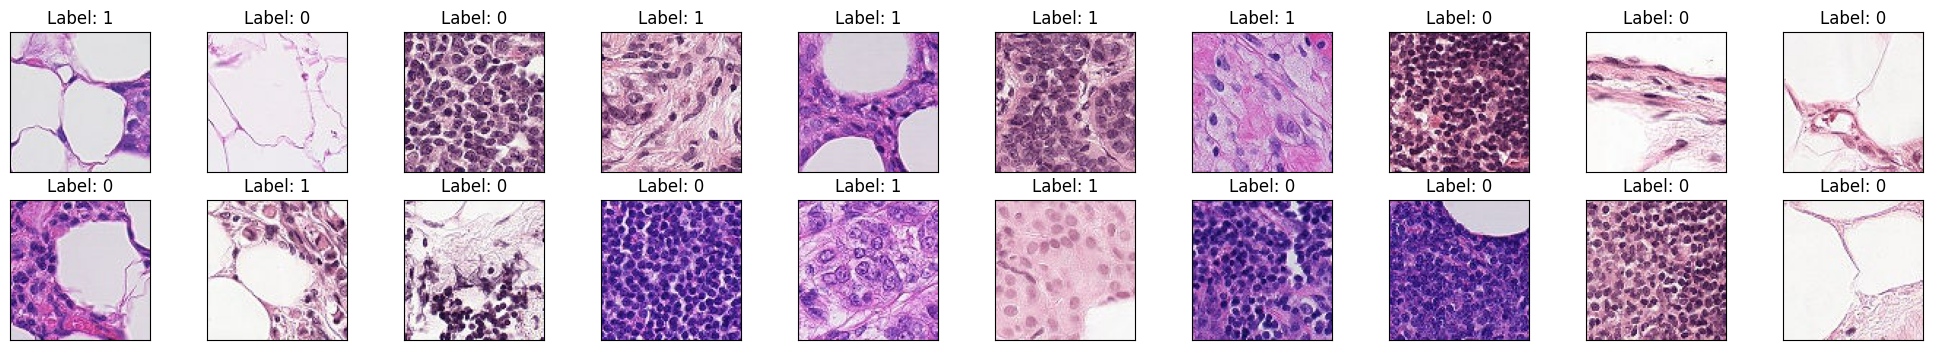

In [2]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from PIL import Image

# Read in the training labels CSV file
train_df = pd.read_csv("histopathologic-cancer-detection/train_labels.csv")

# Create a figure object with a size of 25 inches by 4 inches
fig = plt.figure(figsize=(25, 4))

# Display 20 images (2 rows of 10)
train_imgs = os.listdir("histopathologic-cancer-detection/train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    # Add a subplot for each image, with no x or y ticks
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    # Open the image file using PIL
    im = Image.open("histopathologic-cancer-detection/train/" + img)
    # Display the image using matplotlib
    plt.imshow(im)
    # Extract the label of the image from the train_df dataframe
    lab = train_df.loc[train_df['id'] == img.split('.')[0], 'label'].values[0]
    # Set the title of the subplot to be the image's label
    ax.set_title(f'Label: {lab}')
    
# Display the figure
plt.show()


## Exploratory Data Analysis (EDA) - Inspect, Visualize and Clean the Data
Let's start of by taking a look at the complete training set. The histogram below shows the distribution of the positive/negative labels. We can see that about 41% of the data is labeled as "positive" (1), while 59% is labeled as "negative" (0).

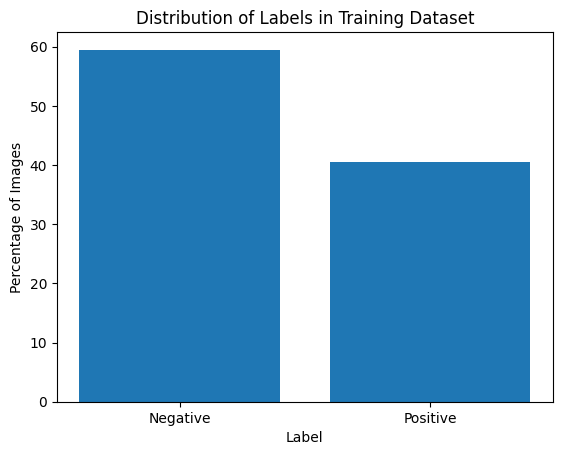

In [3]:
import matplotlib.pyplot as plt

# Count the number of images with each label
label_counts = train_df["label"].value_counts()

# Calculate the label distribution as a percentage
label_percentages = label_counts / label_counts.sum() * 100

# Create a bar chart showing the label distribution
plt.bar(label_percentages.index, label_percentages.values)
plt.xticks([0, 1], ["Negative", "Positive"])
plt.xlabel("Label")
plt.ylabel("Percentage of Images")
plt.title("Distribution of Labels in Training Dataset")
plt.show()

Fortunately, the data does not need much cleaning. Since the groups are rougly balanced, we don't need sophisticated stratification techniques to adjust imbalances. Finally, lets look at the number of images in both the training and external test data.

In [4]:
# Count the number of images in the sets
num_test_images = len(os.listdir("histopathologic-cancer-detection/test"))
num_train_images = len(train_df)
# Print the number of images in each dataset
print('No. of images in training dataset:', num_train_images)
print('No. of images in testing dataset:', num_test_images)


No. of images in training dataset: 220025
No. of images in testing dataset: 57458


We have 220025 images in the training dataset, which we still need to split in a true training set and an internal validation set, and then we have 57458 images in the test set, which we need to predict.

## Data Preprocessing
Now that we have inspected and split the data, we can start creating the model architecture. I would have liked to use the tensorflow/keras libraries, but after a day of trying to get those working on the Mac M1 chip without success, I decided to use PyTorch instead. First, we need to create a custom PyTorch dataset using the "torch.utils.data.Dataset" class.

In [5]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import os

class HistopathologicCancerDataset(Dataset):
    def __init__(self, labels_df, img_dir, transform=None):
        self.labels_df = labels_df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_id = self.labels_df.iloc[idx]['id']
        img_path = os.path.join(self.img_dir, f'{img_id}.tif')
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)

        label = self.labels_df.iloc[idx]['label']
        return img, label


Secondly, we need to create transormers to crop the image, flipping the images, converting them to tensors, and normalizing the pixel values from 0-255 to 0-1.

In [6]:
# Import the required libraries
import os
import pandas as pd
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

# Define the transformations for the training data
transforms_train = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define the transformations for the validation and test data
transforms_val = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


Next, we can create instances of this class and create them as loaders. At this point, we should split the dataset into a train and validation set (since we can only use the external test set for the Kaggle submission). Since there are no substantial imbalances, we can just do an unstratified 80/20 split.

In [7]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Load the labels CSV file into a Pandas DataFrame
train_df = pd.read_csv("histopathologic-cancer-detection/train_labels.csv")

# Define the path to the image directory
img_dir = "histopathologic-cancer-detection/train"

# Split the training dataset into train and test
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=123)

# Create instances of the HistopathologyDataset class for the training and validation datasets
train_dataset = HistopathologicCancerDataset(train_data, img_dir=img_dir, transform=transforms_train)
val_dataset = HistopathologicCancerDataset(val_data, img_dir=img_dir, transform=transforms_val)

# Create data loaders for the training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)


I will also create a smaller subset of the data for the process of evaluating the performance of the model and getting a feeling for the performance. With the complete dataset, that just takes too long. I'll create a reduced set of 1%.

In [14]:
import random

# Reduce the train and validation dataset sizes
subset_size = 0.01
train_subset = random.sample(list(train_data.index), int(len(train_data) * subset_size))
val_subset = random.sample(list(val_data.index), int(len(val_data) * subset_size))

# Create the smaller train and validation datasets using the reduced indices
train_data_reduced = train_data.loc[train_subset].reset_index(drop=True)
val_data_reduced = val_data.loc[val_subset].reset_index(drop=True)

# Create instances of the HistopathologyDataset class for the reduced training and validation datasets
train_dataset_reduced = HistopathologicCancerDataset(train_data_reduced, img_dir=img_dir, transform=transforms_train)
val_dataset_reduced = HistopathologicCancerDataset(val_data_reduced, img_dir=img_dir, transform=transforms_val)

# Create data loaders for the reduced training and validation datasets
train_loader_reduced = DataLoader(train_dataset_reduced, batch_size=32, shuffle=True, num_workers=0)
val_loader_reduced = DataLoader(val_dataset_reduced, batch_size=32, shuffle=False, num_workers=0)


## Model architecture
We are ready to set up the model architecture. From the lectures we have gotten various practical tips for CNN creation. For example, we will use a [Conv-Conv-MaxPool]n structure. We will create an architecture that makes it possible to tune the hyperparameters while fitting the final model. For example, the model will be flexible enough to add additional convolution layers or optimizers.

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl

class CNNImageClassifier(pl.LightningModule):
    def __init__(self, learning_rate=0.001, n_conv_layers=2, optimizer_name='AdamW'):
        super().__init__()
        self.learning_rate = learning_rate
        self.n_conv_layers = n_conv_layers
        self.optimizer_name = optimizer_name

        conv_layers = []
        in_channels = 3
        out_channels = 16
        for i in range(n_conv_layers):
            conv_layers.extend([
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2)
            ])
            in_channels = out_channels
            out_channels *= 2

        self.features = nn.Sequential(*conv_layers)

        self.classifier = nn.Sequential(
            nn.Linear(in_features=8 * 8 * in_channels, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(in_features=256, out_features=2)
        )

        self.loss = nn.CrossEntropyLoss()
        self.save_hyperparameters()

    def forward(self, input):
        output = self.features(input)
        output = output.view(-1, 8 * 8 * 32)
        output = self.classifier(output)
        return output

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        train_accuracy = self.binary_accuracy(outputs, targets)
        loss = self.loss(outputs, targets)
        self.log('train_accuracy', train_accuracy, prog_bar=True)
        self.log('train_loss', loss)
        return {"loss": loss, "train_accuracy": train_accuracy}

    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.forward(inputs)
        test_accuracy = self.binary_accuracy(outputs, targets)
        loss = self.loss(outputs, targets)
        self.log('test_accuracy', test_accuracy)
        return {"test_loss": loss, "test_accuracy": test_accuracy}

    def configure_optimizers(self):
        params = self.parameters()
        
        if self.optimizer_name == 'AdamW':
            optimizer = optim.AdamW(params=params, lr=self.learning_rate, weight_decay=0.0001)
        elif self.optimizer_name == 'SGD':
            optimizer = optim.SGD(params=params, lr=self.learning_rate, momentum=0.9, weight_decay=0.0001)
        else:
            raise ValueError(f"Invalid optimizer name '{self.optimizer_name}', choose either 'AdamW' or 'SGD'.")

        return optimizer

    # Calculate accuracy for each batch at a time
    def binary_accuracy(self, outputs, targets):
        _, outputs = torch.max(outputs, 1)
        correct_results_sum = (outputs == targets).sum().float()
        acc = correct_results_sum / targets.shape[0]
        return acc

    def predict_step(self, batch, batch_idx):
        return self(batch)


## Results

Now, we will create a function with which we can train the model with various settings and see what works best:

In [26]:
import numpy as np
from sklearn.metrics import roc_auc_score

def train_CNNImageClassifier(train_loader, val_loader, n_epochs, learning_rate):
    # Initialize the model
    model = CNNImageClassifier(learning_rate=learning_rate)

    # Specify loss function (Categorical Cross-Entropy loss)
    criterion = nn.CrossEntropyLoss()

    # Specify optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize variables for early stopping and tracking metrics
    valid_loss_min = np.Inf
    train_losses, valid_losses, val_auc, auc_epoch = [], [], [], []

    for epoch in range(n_epochs):
        # Initialize losses for the current epoch
        train_loss, valid_loss = 0.0, 0.0

        # Train the model
        model.train()
        for data, target in train_loader:
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
            optimizer.zero_grad()

        # Validate the model
        model.eval()
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item() * data.size(0)
                y_actual = target.data.cpu().numpy()
                y_pred = torch.softmax(output, dim=1).detach().cpu().numpy()[:, 1]
                val_auc.append(roc_auc_score(y_actual, y_pred))

        # Calculate and store average losses and AUC
        train_loss /= len(train_loader.sampler)
        valid_loss /= len(val_loader.sampler)
        valid_auc = np.mean(val_auc)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        auc_epoch.append(valid_auc)

        # Print training/validation statistics
        print(f'Epoch: {epoch+1} | Training Loss: {train_loss:.6f} | Validation Loss: {valid_loss:.6f} | Validation AUC: {valid_auc:.4f}')

        # Early stopping
        if valid_loss <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model ...')
            torch.save(model.state_dict(), 'best_model.pt')
            valid_loss_min = valid_loss

        import matplotlib.pyplot as plt

    def plot_losses(train_losses, valid_losses):
        plt.plot(train_losses, label='Training loss')
        plt.plot(valid_losses, label='Validation loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Losses')
        plt.show()

    # Call the function to plot the losses
    plot_losses(train_losses, valid_losses)



First, let's evaluate the performance of the model with various settings. We'll do this on the reduced dataset so it will not take too long. The first version will take 10 epochs and a learning rate of 0.01.

Epoch: 1 | Training Loss: 1.992757 | Validation Loss: 0.614311 | Validation AUC: 0.7892
Validation loss decreased (inf --> 0.614311). Saving model ...
Epoch: 2 | Training Loss: 0.634037 | Validation Loss: 0.551935 | Validation AUC: 0.7955
Validation loss decreased (0.614311 --> 0.551935). Saving model ...
Epoch: 3 | Training Loss: 0.622086 | Validation Loss: 0.623028 | Validation AUC: 0.7970
Epoch: 4 | Training Loss: 0.630136 | Validation Loss: 0.610970 | Validation AUC: 0.7890
Epoch: 5 | Training Loss: 0.640606 | Validation Loss: 0.559118 | Validation AUC: 0.7918
Epoch: 6 | Training Loss: 0.628834 | Validation Loss: 0.583513 | Validation AUC: 0.7965
Epoch: 7 | Training Loss: 0.623406 | Validation Loss: 0.540211 | Validation AUC: 0.8039
Validation loss decreased (0.551935 --> 0.540211). Saving model ...
Epoch: 8 | Training Loss: 0.621346 | Validation Loss: 0.596581 | Validation AUC: 0.8068
Epoch: 9 | Training Loss: 0.624844 | Validation Loss: 0.552923 | Validation AUC: 0.8105
Epoch: 10

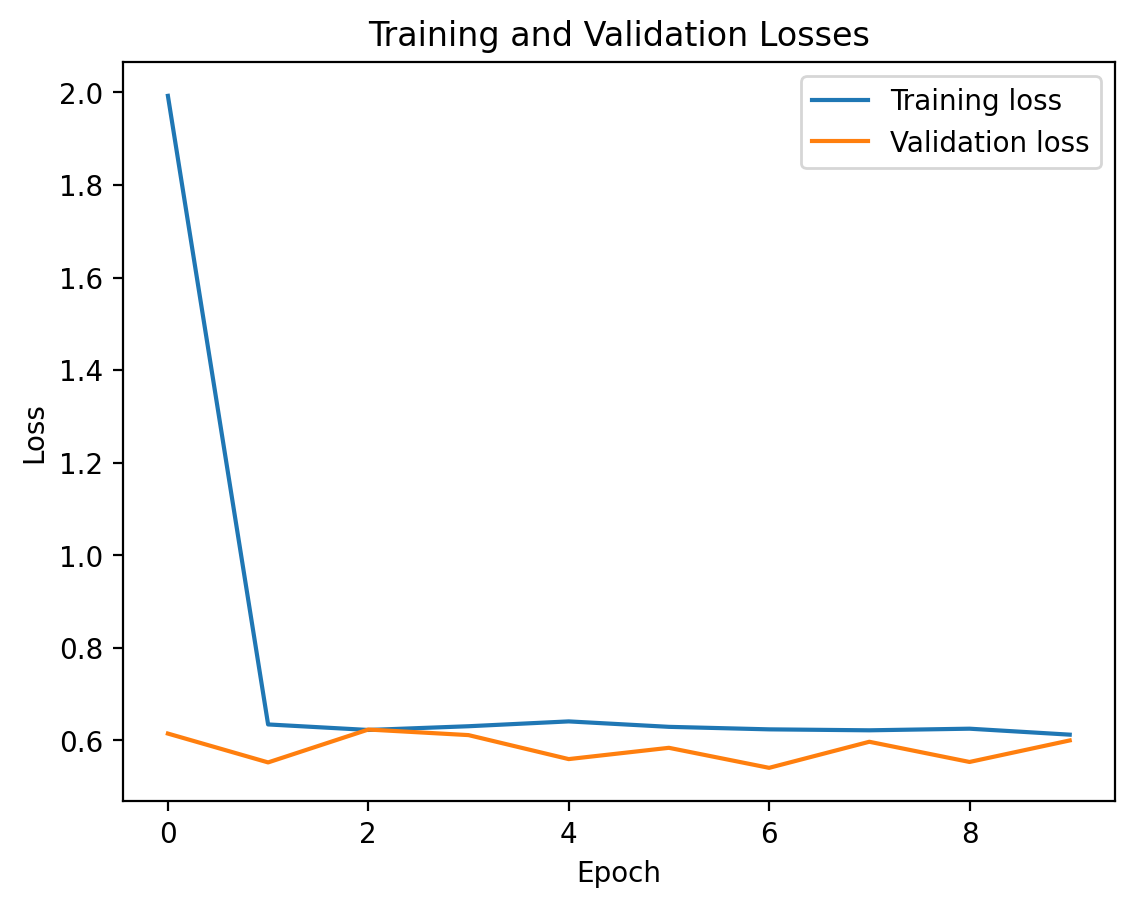

In [32]:
torch.manual_seed(123)
train_CNNImageClassifier(train_loader_reduced, val_loader_reduced, n_epochs=10, learning_rate=0.01)


This approach led us to final AUC of 0.8133. However, we can see that there are some weird patterns in the training/validation losses, with a high loss in the beginning. Let's see what happens when we decrease the learning rate to 0.001:

Epoch: 1 | Training Loss: 0.664547 | Validation Loss: 0.502589 | Validation AUC: 0.8321
Validation loss decreased (inf --> 0.502589). Saving model ...
Epoch: 2 | Training Loss: 0.538394 | Validation Loss: 0.490867 | Validation AUC: 0.8434
Validation loss decreased (0.502589 --> 0.490867). Saving model ...
Epoch: 3 | Training Loss: 0.528198 | Validation Loss: 0.483152 | Validation AUC: 0.8482
Validation loss decreased (0.490867 --> 0.483152). Saving model ...
Epoch: 4 | Training Loss: 0.519623 | Validation Loss: 0.470546 | Validation AUC: 0.8516
Validation loss decreased (0.483152 --> 0.470546). Saving model ...
Epoch: 5 | Training Loss: 0.493806 | Validation Loss: 0.456741 | Validation AUC: 0.8556
Validation loss decreased (0.470546 --> 0.456741). Saving model ...
Epoch: 6 | Training Loss: 0.502473 | Validation Loss: 0.487505 | Validation AUC: 0.8568
Epoch: 7 | Training Loss: 0.486503 | Validation Loss: 0.475202 | Validation AUC: 0.8566
Epoch: 8 | Training Loss: 0.497010 | Validation L

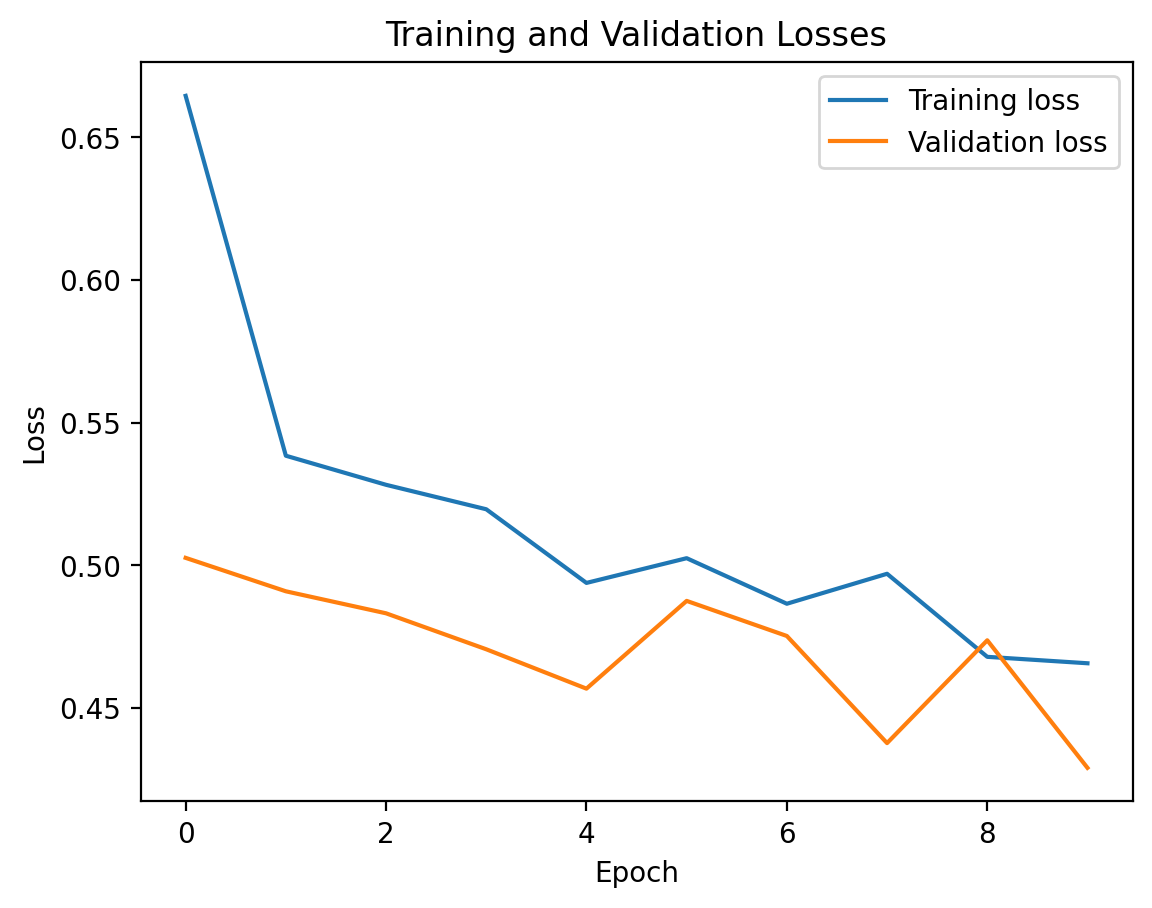

In [28]:
torch.manual_seed(123)
train_CNNImageClassifier(train_loader_reduced, val_loader_reduced, n_epochs=10, learning_rate=0.001)

The AUC got significantly better during this approach. However, both the validation and training loss still seem to be improving when we stop the epochs. Let's try and see how well we do when increasing the number of epochs.

Epoch: 1 | Training Loss: 0.664547 | Validation Loss: 0.502589 | Validation AUC: 0.8321
Validation loss decreased (inf --> 0.502589). Saving model ...
Epoch: 2 | Training Loss: 0.538394 | Validation Loss: 0.490867 | Validation AUC: 0.8434
Validation loss decreased (0.502589 --> 0.490867). Saving model ...
Epoch: 3 | Training Loss: 0.528198 | Validation Loss: 0.483152 | Validation AUC: 0.8482
Validation loss decreased (0.490867 --> 0.483152). Saving model ...
Epoch: 4 | Training Loss: 0.519623 | Validation Loss: 0.470546 | Validation AUC: 0.8516
Validation loss decreased (0.483152 --> 0.470546). Saving model ...
Epoch: 5 | Training Loss: 0.493806 | Validation Loss: 0.456741 | Validation AUC: 0.8556
Validation loss decreased (0.470546 --> 0.456741). Saving model ...
Epoch: 6 | Training Loss: 0.502473 | Validation Loss: 0.487505 | Validation AUC: 0.8568
Epoch: 7 | Training Loss: 0.486503 | Validation Loss: 0.475202 | Validation AUC: 0.8566
Epoch: 8 | Training Loss: 0.497010 | Validation L

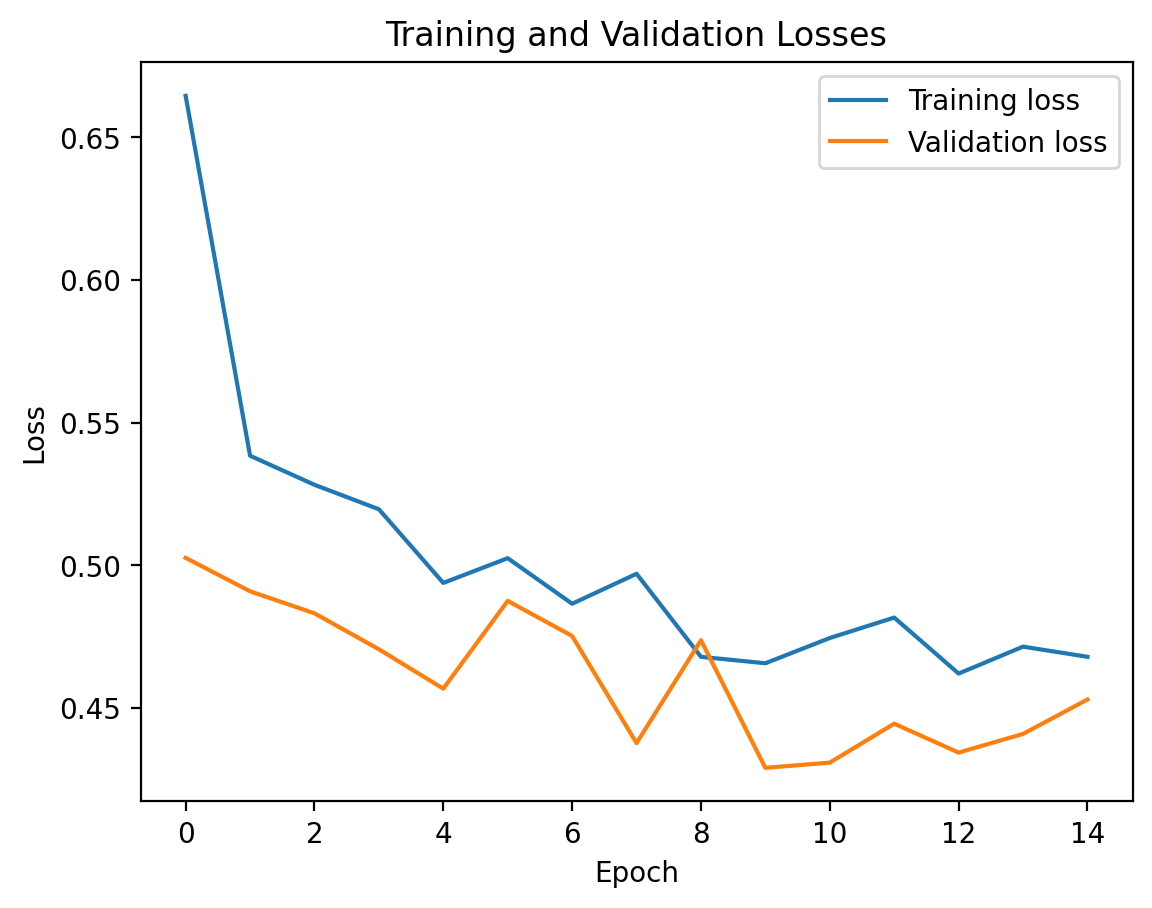

In [41]:
torch.manual_seed(123)
train_CNNImageClassifier(train_loader_reduced, val_loader_reduced, n_epochs=15, learning_rate=0.001)

We seem to have found a fair model with stabilizing losses in the end. We'll use these settings to train the model on the full dataset. Notably, we could also look into adding additional convolution layers. However, for the full dataset, the current approach will already take about an hour to train. Therefore, we kept to a standardized number of convolution layers.

Epoch: 1 | Training Loss: 0.434442 | Validation Loss: 0.371278 | Validation AUC: 0.9141
Validation loss decreased (inf --> 0.371278). Saving model ...
Epoch: 2 | Training Loss: 0.382600 | Validation Loss: 0.332178 | Validation AUC: 0.9229
Validation loss decreased (0.371278 --> 0.332178). Saving model ...
Epoch: 3 | Training Loss: 0.356250 | Validation Loss: 0.313518 | Validation AUC: 0.9286
Validation loss decreased (0.332178 --> 0.313518). Saving model ...
Epoch: 4 | Training Loss: 0.340377 | Validation Loss: 0.298791 | Validation AUC: 0.9328
Validation loss decreased (0.313518 --> 0.298791). Saving model ...
Epoch: 5 | Training Loss: 0.329903 | Validation Loss: 0.279500 | Validation AUC: 0.9362
Validation loss decreased (0.298791 --> 0.279500). Saving model ...
Epoch: 6 | Training Loss: 0.319559 | Validation Loss: 0.286350 | Validation AUC: 0.9384
Epoch: 7 | Training Loss: 0.312250 | Validation Loss: 0.297895 | Validation AUC: 0.9395
Epoch: 8 | Training Loss: 0.305520 | Validation L

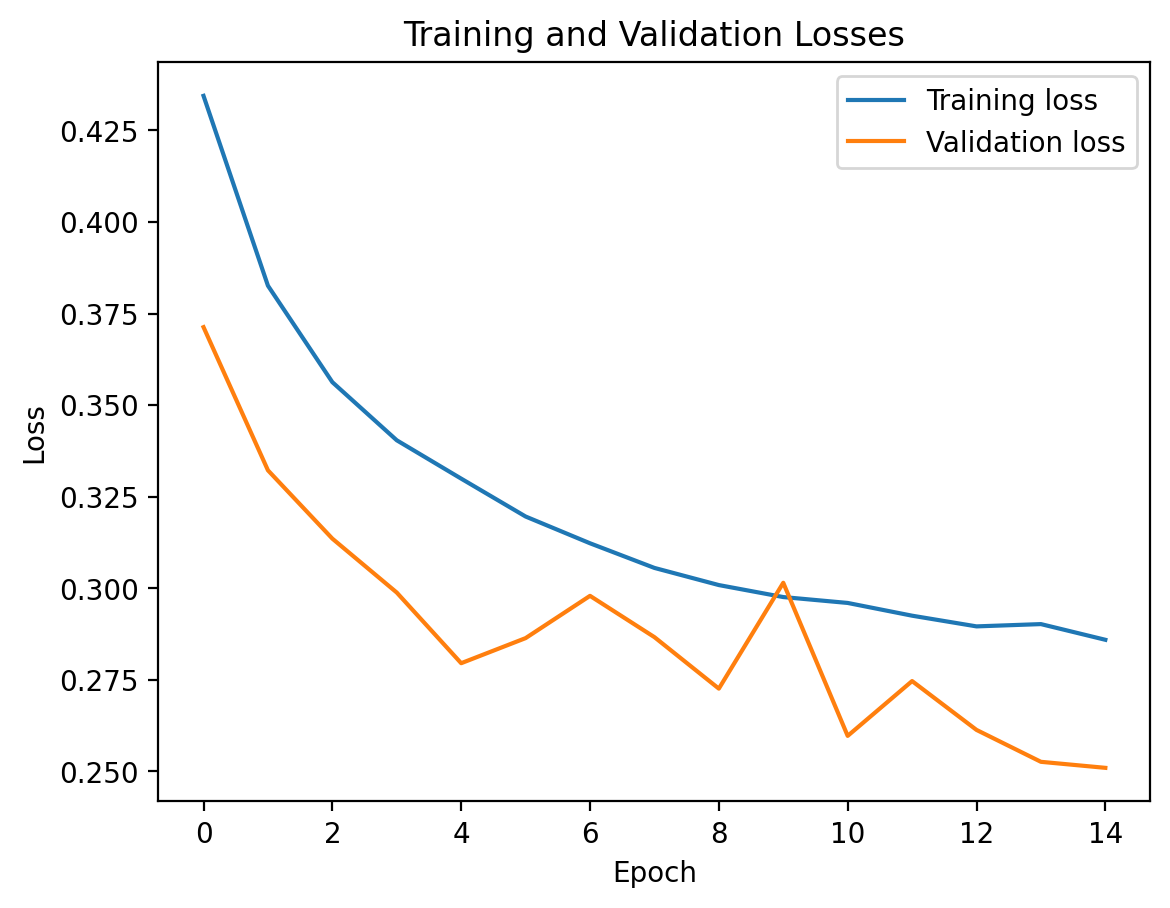

In [42]:
torch.manual_seed(123)
train_CNNImageClassifier(train_loader, val_loader, n_epochs=15, learning_rate=0.001)

The final training run with the full dataset took 70 minutes, but did very significantly decrease loss and increase the AUC performance. 

## Analysis / discussion
We have created a CNN image classifier to detect histopathological traits of cancer. We have implemented a specific [conv-conv-maxpool]n structure which was recommended in the lectures. We also used batch normalization and dropout layers to prevent overfitting. We did try some variations of the model with different learning rates and epochs to get to a more specifically tuned model. However, the very large numbers of images made it hard for me to truly do hyperparameters searchers across the full dataset and with many option. In future iterations, I could further experiment with hyperparameter optimization, pretrained models, deeper architectures, learning rate scheduling and regularization. The size of the data truly made this challenging, just as the issues with using tensorflow on Mac M1.

In the final training run with the complete model, 15 epochs, and a learning rate of 0.001, we can see that both the training and validation losses are still on a downward trajectory, indicating that we might even to better by increasing the number of epochs even more. For this assignment, we will use the model as is an go on to make the final predictions.

## Final predictions
Now that we have the final model trained, we can make the predictions on the test set. Let's first preprocess those images similar to how we did with the training data:

In [43]:
class HistopathologicCancerTestDataset(Dataset):
    def __init__(self, img_ids, img_dir, transform=None):
        self.img_ids = img_ids
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_path = os.path.join(self.img_dir, f'{img_id}.tif')
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)

        return img, img_id

# Load the sample_submission.csv file
sample_submission_df = pd.read_csv("histopathologic-cancer-detection/sample_submission.csv")

# Define the path to the test image directory
test_img_dir = "histopathologic-cancer-detection/test"

# Create an instance of the HistopathologicCancerTestDataset class for the test dataset
test_dataset = HistopathologicCancerTestDataset(sample_submission_df['id'].values, img_dir=test_img_dir, transform=transforms_val)

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


Now, let's use our finalized model to make predictions on the test set and update the submission file for Kaggle:

In [44]:
def predict_test_data(test_loader):
    # Create an instance of the CNNImageClassifier and load the trained model
    model = CNNImageClassifier()
    model.load_state_dict(torch.load('best_model.pt'))
    model.eval()

    # Make predictions on the test dataset
    predictions = {}
    with torch.no_grad():
        for data, img_ids in test_loader:
            output = model(data)
            probs = torch.softmax(output, dim=1).detach().cpu().numpy()[:, 1]
            for img_id, prob in zip(img_ids, probs):
                predictions[img_id] = prob

    return predictions

predictions = predict_test_data(test_loader)

# Update the 'label' column in the sample_submission_df DataFrame with the predicted labels
sample_submission_df['label'] = sample_submission_df['id'].map(predictions)

# Save the updated DataFrame to a new CSV file
sample_submission_df.to_csv("histopathologic-cancer-detection/final_submission.csv", index=False)



## Conclusion

We have created predictions for the Kaggle competition on Histopathological cancer detection. When uploading these predictions to the Kaggle website, we got to the following scores:

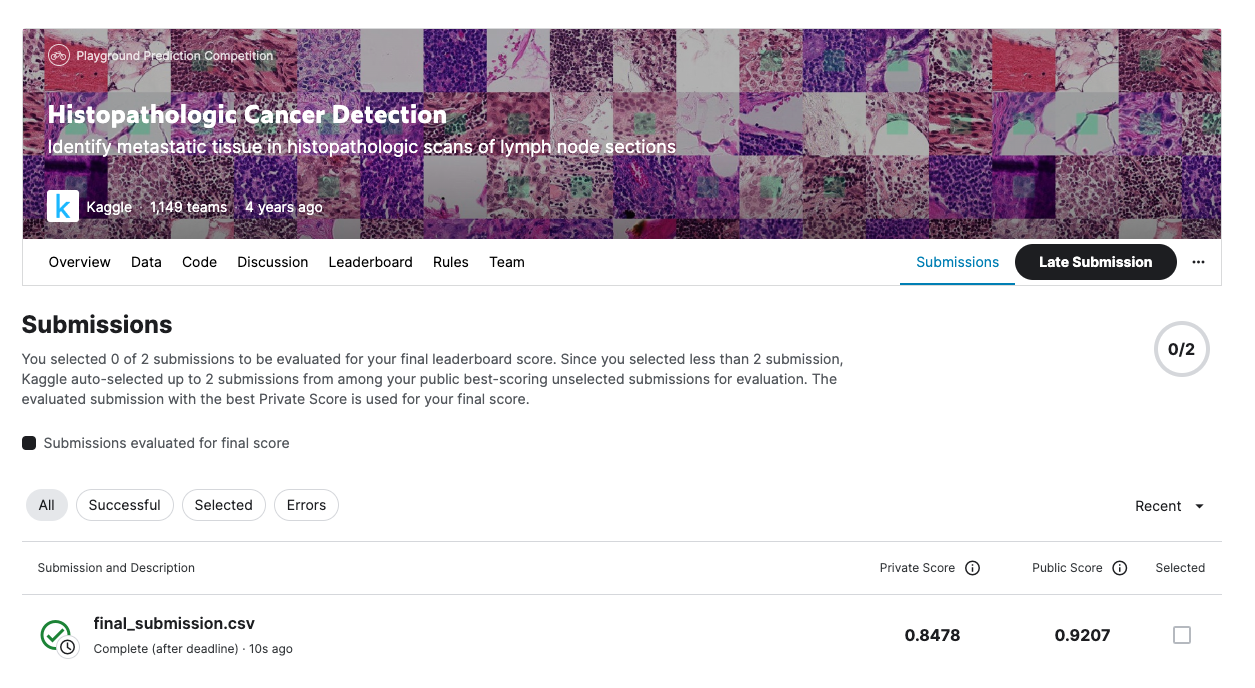

In [46]:
from IPython import display
display.Image("histopathologic-cancer-detection/Screenshot.png")

We can see that got to a public score of 0.9207, which is certainly fair. It would have gotten us to the 829th place on the leaderboard.

 As discussed before, we have created a CNN image classifier to detect histopathological traits of cancer. We have implemented a specific [conv-conv-maxpool]n structure which was recommended in the lectures. We also used batch normalization and dropout layers to prevent overfitting. We did try some variations of the model with different learning rates and epochs to get to a more specifically tuned model. However, the very large numbers of images made it hard for me to truly do hyperparameters searchers across the full dataset and with many option. In future iterations, I could further experiment with hyperparameter optimization, pretrained models, deeper architectures, learning rate scheduling and regularization. Especially the addition of more convolution layers was something I would have liked to experiment with, but with a training time of 70 minutes in the current form, it was infeasible to further deepen the structure for this specific assignment.

### GitHub Repo: https://github.com/michielschinkel/Deep-Learning